# 머신러닝을 이용한 가뭄예측

## 한글데이터 처리를 위한 사전작업

In [1]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

**(Runtime 재시작 필요)**

In [2]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl 
# %matplotlib inline

# plt.rcParams['axes.unicode_minus'] = False

# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = mpl.font_manager.FontProperties(fname=path).get_name()
# mpl.rc('font', family=font_name)
# mpl.font_manager._rebuild()

In [41]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc 

get_ipython().run_line_magic("matplotlib", "inline")

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc("font", family=font_name)
else:
    print("Unkown system. sorry~~")

plt.rc('axes', unicode_minus=False)

## 데이터 수집
- 기상자료개방포털(https://data.kma.go.kr)에서 다운로드 
- Feature: 종관기상관측(ASOS)
- Label: 표준강수지수

## 데이터 가공

### 파일 읽기

In [2]:
import os

files = os.listdir('../data')
asos_csv_files = [file for file in files if file.startswith("OBS_ASOS_")]
asos_csv_files[:2]

['OBS_ASOS_DD_19900701_19901231.csv', 'OBS_ASOS_DD_19910101_20001231.csv']

In [3]:
import pandas as pd

tmp = []
for csv_file in asos_csv_files:
  tmp.append(pd.read_csv('../data/' + csv_file, encoding='euc-kr'))

asos_raw = pd.concat(tmp)
asos_raw.head(2)

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 이슬점온도(°C),평균 상대습도(%),평균 현지기압(hPa)
0,90,속초,1990-07-01,16.5,14.9,19.5,0.3,2.2,15.2,92.0,1012.8
1,90,속초,1990-07-02,16.2,14.9,17.2,21.3,3.2,15.6,95.5,1008.8


In [4]:
asos = asos_raw[['지점', '일시'
                , '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '평균 현지기압(hPa)'
                , '일강수량(mm)', '평균 풍속(m/s)', '평균 이슬점온도(°C)', '평균 상대습도(%)']].copy()
asos.rename(columns = {
    '평균기온(°C)' : '평균기온',
    '최저기온(°C)' : '최저기온',
    '최고기온(°C)' : '최고기온',
    '평균 현지기압(hPa)' : '기압',
    '일강수량(mm)' : '강수량',
    '평균 풍속(m/s)' : '풍속',
    '평균 이슬점온도(°C)' : '이슬점',
    '평균 상대습도(%)' : '상대습도'
    }, inplace = True)
asos.sort_values('일시' ,inplace=True)
asos.reset_index(drop=True, inplace=True)
asos.head(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0
1,277,1990-07-01,18.3,16.5,20.4,1005.4,NaN,4.0,13.9,76.0


In [5]:
asos.tail(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도
279789,212,2022-05-31,18.8,11.4,27.4,991.6,NaN,1.5,6.6,50.5
279790,281,2022-05-31,23.0,16.9,30.4,996.9,NaN,2.2,7.3,41.1


In [6]:
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279791 entries, 0 to 279790
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      279791 non-null  int64  
 1   일시      279791 non-null  object 
 2   평균기온    279734 non-null  float64
 3   최저기온    279784 non-null  float64
 4   최고기온    279783 non-null  float64
 5   기압      279727 non-null  float64
 6   강수량     100734 non-null  float64
 7   풍속      279728 non-null  float64
 8   이슬점     279692 non-null  float64
 9   상대습도    279676 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 21.3+ MB


#### 결측치를 확인 및 수정
- 결측치를 확인하기 위해 isna() 함수를 이용.
- 강수량의 경우, 비가 내리지 않는날에 대하여 값이 들어오지 않음을 확인 -> 0으로 변경
- 나머지 결측치의 경우, 날씨의 연속성을 고려하여 전일자 데이터로 채움.

In [7]:
asos.isna().sum()

지점           0
일시           0
평균기온        57
최저기온         7
최고기온         8
기압          64
강수량     179057
풍속          63
이슬점         99
상대습도       115
dtype: int64

In [8]:
asos['강수량'] = asos['강수량'].fillna(0)
asos = asos.fillna(method='ffill')
asos.isna().sum()

지점      0
일시      0
평균기온    0
최저기온    0
최고기온    0
기압      0
강수량     0
풍속      0
이슬점     0
상대습도    0
dtype: int64

#### ASOS 관측데이터의 6개월 평균값 계산
- Label인 SPI6는 6개월 표준강수지수 이기때문에 두 Feature 값을 모두 6개월 평균 가공

In [9]:
asos['연도'] = asos['일시'].map(lambda x: x.split('-')[0])
asos['월'] = asos['일시'].map(lambda x: x.split('-')[1])
asos.head(2)

,지점,일시,평균기온,최저기온,최고기온,기압,강수량,풍속,이슬점,상대습도,연도,월
0,90,1990-07-01,16.5,14.9,19.5,1012.8,0.3,2.2,15.2,92.0,1990,07
1,277,1990-07-01,18.3,16.5,20.4,1005.4,0.0,4.0,13.9,76.0,1990,07


In [10]:
asos_mean = asos.groupby(by=['지점', '연도', '월']).mean()
asos_mean.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 1990 07  21.425806  19.451613  24.387097  1005.903226  8.477419  2.390323   
        08  24.683871  21.616129  28.274194  1006.703226  3.564516  2.209677   

                  이슬점       상대습도  
지점 연도   월                         
90 1990 07  19.938710  91.925806  
        08  21.967742  85.945161

#### 지점별로 6개월씩 rolling 함수를 이용하여 평균값을 연산

In [11]:
asos_pos_list = list(set(asos_mean.index.map(lambda x: x[0])))

tmp = []
for pos in asos_pos_list:
    tmp.append(pd.concat([asos_mean.loc[pos].rolling(window=6).mean().dropna()], keys=[pos], names=['지점']))

asos_mean_6m = pd.concat(tmp)
asos_mean_6m.head()

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
129 1990 12  16.115466  11.923459  21.463136  1013.037455  5.297903  1.957455   
    1991 01  11.696649   7.230448  17.316900  1016.229391  4.033387  1.790789   
         02   7.288411   2.807675  12.876231  1018.844963  2.998671  1.889272   
         03   4.551171  -0.032002  10.230031  1020.095375  1.590678  1.974128   
         04   4.074756  -0.592898   9.807862  1019.495662  1.922901  2.086404   

                   이슬점       상대습도  
지점  연도   월                         
129 1990 12  12.064068  78.620968  
    1991 01   7.369982  76.798387  
         02   2.783077  75.348368  
         03  -0.212855  73.766594  
         04  -0.940256  72.506540

### 테스트 데이터 준비하기
- 테스트 데이터의 구성은 이전 5개월의 월 평균값의 합 + 최근 20년간 해당 월 평균값을 6으로 나눈 수치

In [12]:
asos_mean.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 1990 07  21.425806  19.451613  24.387097  1005.903226  8.477419  2.390323   
        08  24.683871  21.616129  28.274194  1006.703226  3.564516  2.209677   

                  이슬점       상대습도  
지점 연도   월                         
90 1990 07  19.938710  91.925806  
        08  21.967742  85.945161

#### 이전 5개월 월 평균의 합

In [13]:
tmp = []

for pos in asos_pos_list:
    tmp.append(pd.concat([asos_mean.loc[pos].rolling(window=5).sum().dropna()], keys=[pos], names=['지점']))

asos_mean_5m = pd.concat(tmp)
asos_mean_priv_5m = asos_mean_5m.shift(1).dropna()
asos_mean_priv_5m.head()

평균기온       최저기온        최고기온           기압        강수량  \
지점  연도   월                                                              
129 1990 12  94.889570  73.440753  122.572366  5056.973118  30.242258   
    1991 01  71.863763  49.360108  100.382043  5074.708602  23.577742   
         02  44.641183  22.024624   72.978817  5092.537634  16.377742   
         03  23.003802   0.066052   51.164055  5101.846444   7.305361   
         04  13.161866  -8.330722   39.770507  5102.920637   9.544071   

                    풍속        이슬점        상대습도  
지점  연도   월                                     
129 1990 12   9.480215  74.819892  396.548387  
    1991 01   9.009247  50.648925  388.000000  
         02   9.196344  22.419892  379.758065  
         03   9.418963  -0.244869  371.780207  
         04  10.435092 -10.044869  369.009240

#### 최근 20년간 해당 월의 평균값

In [14]:
asos_mean_sort_month = asos_mean.swaplevel().sort_index().shift(1)
asos_mean_sort_month.head()

평균기온      최저기온      최고기온           기압       강수량        풍속  \
지점 월  연도                                                                    
90 01 1991       NaN       NaN       NaN          NaN       NaN       NaN   
      1992 -0.661290 -4.012903  3.332258  1020.174194  0.587097  2.848387   
      1993  1.716129 -1.941935  5.938710  1019.512903  2.777419  3.170968   
      1994  0.167742 -3.435484  4.300000  1020.425806  2.548387  2.951613   
      1995  0.458065 -3.661290  4.038710  1018.354839  2.312903  2.977419   

                 이슬점       상대습도  
지점 월  연도                         
90 01 1991       NaN        NaN  
      1992 -9.038710  57.103226  
      1993 -5.987097  59.264516  
      1994 -4.087097  73.938710  
      1995 -6.735484  60.890323

In [15]:
tmp = []

for idx in list(set(asos_mean_sort_month.index.droplevel(2))):
    df = asos_mean_sort_month.loc[idx].rolling(window=20).mean().dropna()
    tmp.append(pd.concat([df], keys=[idx], names=['지점', '월']))

asos_mean_20y = pd.concat(tmp).sort_index()
asos_mean_20y.head()

평균기온      최저기온      최고기온           기압       강수량        풍속  \
지점 월  연도                                                                    
90 01 2011  0.035323 -3.830484  4.137419  1019.001774  1.456613  2.934839   
      2012 -0.068065 -3.989839  4.059839  1019.028710  1.446613  2.928871   
      2013 -0.174194 -4.078710  3.931452  1019.132419  1.346774  2.890806   
      2014 -0.220968 -4.135161  3.873548  1019.176129  1.344032  2.860000   
      2015 -0.150161 -4.082419  3.959032  1019.269677  1.275645  2.828548   

                  이슬점       상대습도  
지점 월  연도                          
90 01 2011  -9.919677  51.109032  
      2012 -10.345323  49.915161  
      2013 -10.673710  49.112742  
      2014 -10.956129  48.166613  
      2015 -11.041290  47.640323

In [16]:
test_merge = pd.merge(left=asos_mean_priv_5m, right=asos_mean_20y, on=['지점', '연도', '월']).dropna().sort_index()
test_merge.head()

평균기온_x     최저기온_x      최고기온_x         기압_x      강수량_x  \
지점 연도   월                                                               
90 2009 07   62.103318  41.577627   83.303149  5055.124040  15.020522   
        08   79.292258  59.745484  100.330108  5042.366667  27.127204   
        09   95.379355  76.980968  115.694624  5034.924731  32.420753   
        10  102.632688  85.067634  122.727957  5035.294731  29.397419   
        11  101.319785  83.657957  121.156989  5039.901183  28.729677   

                 풍속_x      이슬점_x      상대습도_x     평균기온_y     최저기온_y     최고기온_y  \
지점 연도   월                                                                       
90 2009 07  13.195776  16.915745  299.360300  22.901425  20.121140  26.175946   
        08  12.565591  41.069892  330.313871  23.711613  20.754355  27.110000   
        09  11.497849  62.837634  354.110645  20.172624  16.567968  24.087903   
        10  10.554516  75.010968  371.830645  15.312489  11.086812  19.833489   
        11  10.554516  72.165806  363.572581   9.208183   5.021177  13.499161   

                   기압_y     강수량_y      풍속_y      이슬점_y     상대습도_y  
지점 연도   월                                                          
90 2009 07  1004.228828  8.056387  2.225097  19.502210  82.218747  
        08  1006.684839  9.145968  2.095000  20.456129  82.798065  
        09  1011.487812  8.055048  2.357753  16.035108  78.086726  
        10  1015.654812  3.016484  2.514349   8.703683  66.912898  
        11  1018.245887  2.790839  2.786247   0.445059  57.421785

In [17]:
for col in asos_mean.columns:
    test_merge[col] = (test_merge[col+'_x'] + test_merge[col+'_y']) / 6
    test_merge.drop(columns=[col+'_x', col+'_y'], inplace=True)

test_merge.head()

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 2009 07  14.167457  10.283128  18.246516  1009.892145  3.846152  2.570145   
        08  17.167312  13.416640  21.240018  1008.175251  6.045529  2.443432   
        09  19.258663  15.591489  23.297088  1007.735424  6.745967  2.309267   
        10  19.657530  16.025741  23.760241  1008.491591  5.402317  2.178144   
        11  18.421328  14.779856  22.442692  1009.691178  5.253419  2.223461   

                  이슬점       상대습도  
지점 연도   월                         
90 2009 07   6.069659  63.596508  
        08  10.254337  68.851989  
        09  13.145457  72.032895  
        10  13.952442  73.123924  
        11  12.101811  70.165728

In [44]:
spi_csv_files = [file for file in files if file.startswith("CLM_SPI_")]
spi_csv_files[:2]

['CLM_SPI_DD_19910101_20001231.csv', 'CLM_SPI_DD_20010101_20101231.csv']

In [45]:
tmp = []
for csv_file in spi_csv_files:
  tmp.append(pd.read_csv('../data/' + csv_file, encoding='euc-kr'))

spi_raw = pd.concat(tmp)
spi_raw.head(2)

,지점,지점명,일시,SPI6
0,90,속초,1991-01-02,1.457
1,90,속초,1991-01-03,1.478


In [46]:
spi = spi_raw[['지점', '일시', 'SPI6']].copy()
spi.sort_values('일시' ,inplace=True)
spi.reset_index(drop=True, inplace=True)
spi.head(2)

,지점,일시,SPI6
0,90,1991-01-02,1.457
1,273,1991-01-02,-0.544


In [47]:
spi.tail(2)

,지점,일시,SPI6
235645,238,2022-06-08,-1.54
235646,238,2022-06-09,-1.61


In [48]:
spi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235647 entries, 0 to 235646
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      235647 non-null  int64  
 1   일시      235647 non-null  object 
 2   SPI6    235647 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.4+ MB


In [49]:
spi['연도'] = spi['일시'].map(lambda x: x.split('-')[0])
spi['월'] = spi['일시'].map(lambda x: x.split('-')[1])
spi.head()

,지점,일시,SPI6,연도,월
0,90,1991-01-02,1.457,1991,01
1,273,1991-01-02,-0.544,1991,01
2,272,1991-01-02,-0.284,1991,01
3,100,1991-01-02,0.860,1991,01
4,238,1991-01-02,-0.695,1991,01


In [50]:
spi_mean = spi.groupby(by=['지점', '연도', '월']).mean()
spi_mean.head()

SPI6
지점 연도   월           
90 1991 01  1.276767
        02  1.782500
        03  0.452613
        04  0.031967
        05 -1.199903

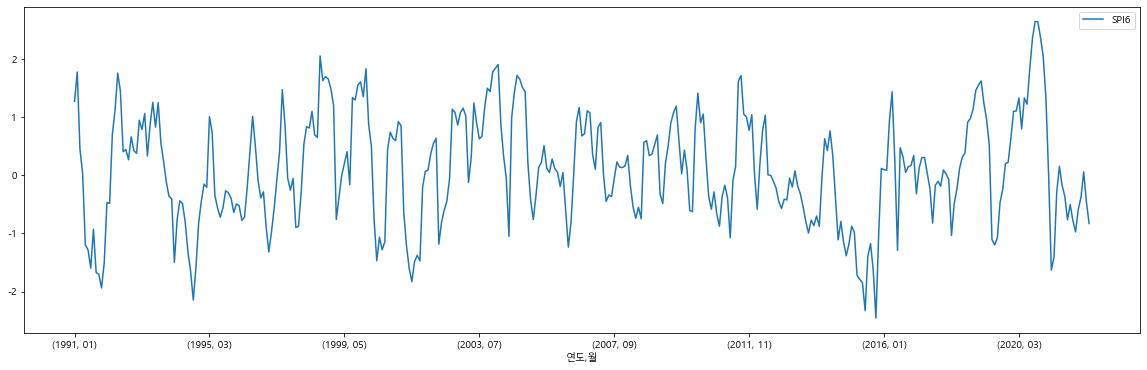

In [51]:
import seaborn as sns

spi_mean.loc[90].plot(figsize=(20, 6));

In [79]:
def label_class(spi):
    if 1 <= spi:            return 0
    elif -1 < spi < 1:      return -1
    elif -1.5 < spi <= -1:  return -2
    elif -2 < spi <= -1.5:  return -3
    elif -2 > spi:          return -4
    

spi_mean['SPI6_OX'] = spi_mean['SPI6'].map(lambda x: 0 if x > -1 else -1)
spi_mean['SPI6_5C'] = spi_mean['SPI6'].map(label_class)
spi_mean.head()

SPI6  SPI6_OX  SPI6_5C
지점 연도   월                             
90 1991 01  1.276767        0        0
        02  1.782500        0        0
        03  0.452613        0       -1
        04  0.031967        0       -1
        05 -1.199903       -1       -2

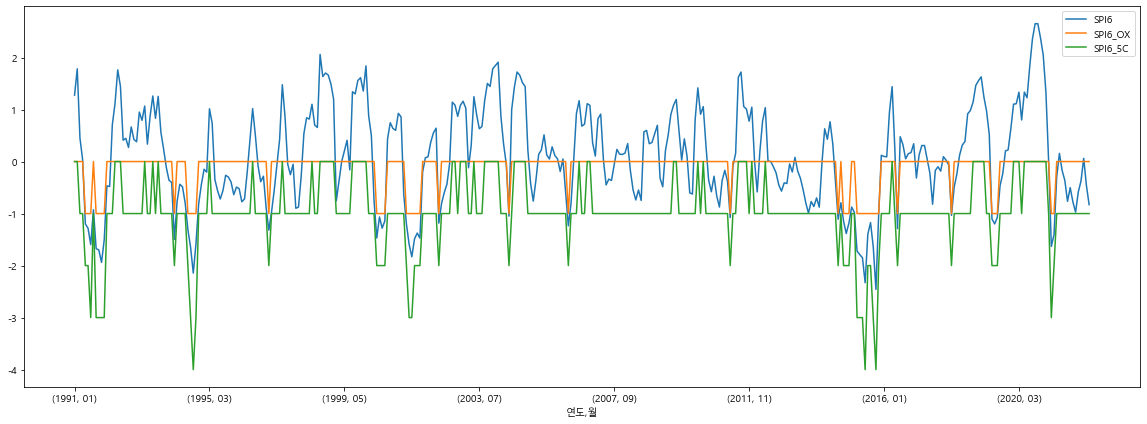

In [80]:
spi_mean.loc[90].plot.line(figsize=(20, 7));

In [81]:
train_data_raw = pd.merge(asos_mean_6m, spi_mean, on=['지점', '연도', '월']).dropna().sort_index()
train_data_raw.head(2)

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                     
90 1991 01  12.095143  8.574409  16.091595  1016.753387  5.460573  2.996685   
        02   7.983546  4.363387  12.017325  1018.632016  5.017083  3.173643   

                 이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점 연도   월                                                    
90 1991 01  6.185932  69.743889  1.276767        0        0  
        02  1.150237  64.995291  1.782500        0        0

In [82]:
train_data = train_data_raw.loc[:,:'2017',:]
train_data

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
90  1991 01  12.095143   8.574409  16.091595  1016.753387  5.460573  2.996685   
         02   7.983546   4.363387  12.017325  1018.632016  5.017083  3.173643   
         03   5.446001   1.862258   9.409816  1019.291013  1.965040  3.280991   
         04   4.738026   1.067294   8.678651  1018.344597  1.681832  3.362102   
         05   5.465911   1.676810   9.428436  1016.539203  1.300721  3.318285   
...                ...        ...        ...          ...       ...       ...   
281 2017 08  19.469122  13.330161  26.231523  1000.428280  2.833011  1.829229   
         09  21.741935  15.762491  28.350287   999.542473  3.163746  1.755197   
         10  21.889265  16.350036  28.281380  1000.830842  3.034427  1.638710   
         11  19.713513  14.276559  26.112294  1002.424211  2.902724  1.608710   
         12  15.930394  10.607778  22.165269  1004.929068  2.875376  1.700269   

                   이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점  연도   월                                                     
90  1991 01   6.185932  69.743889  1.276767        0        0  
         02   1.150237  64.995291  1.782500        0        0  
         03  -1.793742  62.777172  0.452613        0       -1  
         04  -2.867541  61.565291  0.031967        0       -1  
         05  -2.171860  61.805649 -1.199903       -1       -2  
...                ...        ...       ...      ...      ...  
281 2017 08  10.068244  60.516774 -1.147968       -1       -2  
         09  12.991362  63.086487 -1.435833       -1       -2  
         10  14.049857  65.888136 -1.239000       -1       -2  
         11  12.206183  65.984265 -1.218233       -1       -2  
         12   8.196111  64.021219 -0.865226        0       -1  

[6480 rows x 11 columns]

In [83]:
test_data_raw = pd.merge(test_merge, spi_mean, on=['지점', '연도', '월']).dropna().sort_index()
test_data_raw.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 2009 07  14.167457  10.283128  18.246516  1009.892145  3.846152  2.570145   
        08  17.167312  13.416640  21.240018  1008.175251  6.045529  2.443432   

                  이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점 연도   월                                                     
90 2009 07   6.069659  63.596508  1.083484        0        0  
        08  10.254337  68.851989  1.194677        0        0

In [84]:
test_data = test_data_raw.loc[:,'2018':,:]
test_data

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
90  2018 01  11.251927  7.194480  15.269355  1015.516210  3.788530  1.902464   
         02   7.407807  3.039270  11.621082  1017.400150  1.561228  2.049484   
         03   4.597023  0.207711   8.869910  1018.163839  1.633075  2.153167   
         04   4.448274 -0.122687   8.791848  1017.231631  1.348424  2.245463   
         05   6.058358  1.444252  10.639256  1015.781886  1.876758  2.213920   
...                ...       ...        ...          ...       ...       ...   
281 2022 01  11.587258  6.675726  17.662778  1007.746971  2.863817  1.531201   
         02   7.875273  2.421746  14.393959  1009.878348  1.451177  1.605658   
         03   5.340140 -0.600774  12.233719  1010.935307  0.907536  1.794688   
         04   5.179838 -1.055910  12.088504  1009.666947  0.954867  1.923704   
         05   7.110677  0.595821  13.933109  1008.687413  0.906801  1.921883   

                  이슬점       상대습도      SPI6  SPI6_OX  SPI6_5C  
지점  연도   월                                                    
90  2018 01  2.623620  59.475108 -0.071774        0       -1  
         02 -2.803660  52.350947 -1.034571       -1       -2  
         03 -6.654799  48.178038 -0.490871        0       -1  
         04 -7.250312  46.682082 -0.238333        0       -1  
         05 -4.949790  50.144955  0.122484        0       -1  
...               ...        ...       ...      ...      ...  
281 2022 01  6.074830  72.254821  0.212581        0       -1  
         02  1.119202  66.557564  0.430741        0       -1  
         03 -2.806353  60.522564 -0.732258        0       -1  
         04 -3.787916  57.321051 -1.410333       -1       -2  
         05 -2.415045  55.847672 -2.180323       -1       -4  

[1264 rows x 11 columns]

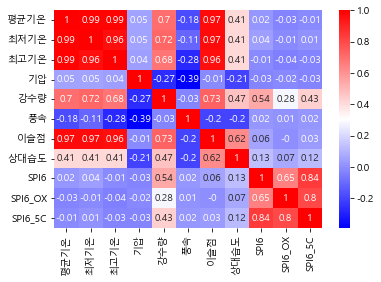

In [85]:
correlation_matrix = train_data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='bwr');

In [86]:
# from sklearn.model_selection import train_test_split
# import numpy as np

# X = train_data.drop(['SPI6'], axis=1)
# y = train_data['SPI6']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# np.unique(y_train, return_counts=True)

In [87]:
X_train = train_data.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
X_test = test_data.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)

y_train = train_data['SPI6_OX']
y_test = test_data['SPI6_OX']

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

drought_tree = DecisionTreeClassifier(random_state=13, max_depth=4)
drought_tree.fit(X_train, y_train)
pred = drought_tree.predict(X_test)

accuracy_score(y_test, pred)

0.8504746835443038

In [89]:
y_train = train_data['SPI6_5C']
y_test = test_data['SPI6_5C']

In [90]:
drought_tree = DecisionTreeClassifier(random_state=13, max_depth=4)
drought_tree.fit(X_train, y_train)
pred = drought_tree.predict(X_test)

accuracy_score(y_test, pred)

0.7096518987341772

In [91]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : range(2, 12)
}

grid_cv = GridSearchCV(drought_tree, param_grid=params, scoring='accuracy', cv=5, return_train_score=True)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=4, random_state=13),
             param_grid={'max_depth': range(2, 12)}, return_train_score=True,
             scoring='accuracy')

In [92]:
grid_cv.best_score_

0.7216049382716049

In [93]:
grid_cv.best_params_

{'max_depth': 2}

In [94]:
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
cv_result_df[['param_max_depth', 'mean_test_score', 'mean_train_score']]

,param_max_depth,mean_test_score,mean_train_score
0,2,0.721605,0.724228
1,3,0.701235,0.730594
2,4,0.717747,0.743519
3,5,0.712809,0.762731
4,6,0.709105,0.780247
5,7,0.677160,0.798727
6,8,0.691512,0.822917
7,9,0.673457,0.845525
8,10,0.659568,0.870370
9,11,0.649074,0.893326


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': range(2, 12),
    'n_estimators': [50, 100, 200, 400],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

drought_forest = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(drought_forest, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 12), 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200, 400]})

In [96]:
grid_cv.best_score_

0.7283950617283951